In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor

# Introduction

In [3]:
data = pd.read_csv('Dataset/emergency_classification.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       2352 non-null   object
 1   emergency_or_not  2352 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 36.9+ KB


In [5]:
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [6]:
data['emergency_or_not'].value_counts()

emergency_or_not
0    1361
1     991
Name: count, dtype: int64

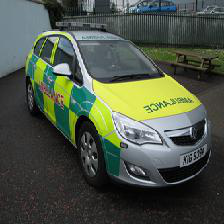

In [7]:
Image.open(os.path.join('Dataset/images', data.iloc[0,0]))

In [8]:
torch.as_tensor(data.iloc[454, 1])

tensor(1)

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        label = self.img_labels.iloc[idx, 1]
        label = torch.as_tensor(label, dtype=torch.float)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [10]:
dataset = CustomImageDataset('Dataset/emergency_classification.csv', 'Dataset/images', 
                             transform=ToTensor())

In [11]:
len(dataset)

2352

In [12]:
dataset.__getitem__(0)[0].shape

torch.Size([3, 224, 224])

In [13]:
dataset[0][0].shape

torch.Size([3, 224, 224])

In [14]:
dataset[0][1].shape

torch.Size([])

In [15]:
dataset[0][0][0].max()

tensor(0.9922)

In [16]:
dataset[0][0].dtype

torch.float32

In [17]:
dataset[0][1].dtype

torch.float32

In [18]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [19]:
len(dataloader)

37

In [20]:
for i, (X, y) in enumerate(dataloader):
    print(X.dtype)
    print(y.dtype)
    break

torch.float32
torch.float32


In [21]:
features, labels = next(iter(dataloader))
print(f"Feature batch shape: {features.size()}, data type: {features.dtype}")
print(f"Labels batch shape: {labels.size()}, data type: {labels.dtype}")

Feature batch shape: torch.Size([64, 3, 224, 224]), data type: torch.float32
Labels batch shape: torch.Size([64]), data type: torch.float32


In [22]:
next(iter(dataloader))[0][43].shape

torch.Size([3, 224, 224])

In [23]:
rng = np.random.default_rng()

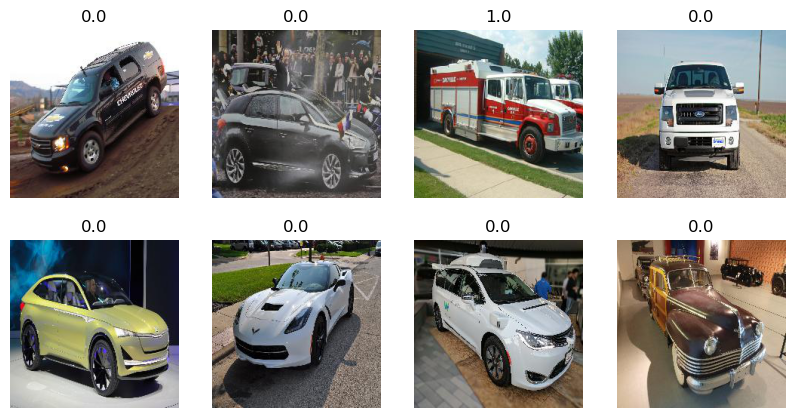

In [24]:
plt.figure(figsize=(10, 5))
sample_data = next(iter(dataloader))
for i in range(8):
    random_number = rng.integers(sample_data[0].shape[0])
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(sample_data[0][random_number].permute(1,2,0))
    plt.title(sample_data[1].numpy()[random_number])
    plt.axis("off")

In [25]:
train_data, test_data = random_split(dataset, [0.75, 0.25])

In [26]:
len(train_data), len(test_data)

(1764, 588)

In [27]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [28]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


# Basic Model

In [29]:
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import roc_curve, precision_recall_curve, det_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay

In [30]:
from torcheval.metrics.functional import binary_accuracy, binary_confusion_matrix
from torcheval.metrics import BinaryAccuracy

In [31]:
from torchinfo import summary

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224*224*3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)
        self.batchnorm = nn.BatchNorm1d(100)
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.batchnorm(x)
        x = self.dropout(x)        
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [42]:
model = Net()

In [43]:
summary(model=model, input_size=(64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [64, 1]                   --
├─Flatten: 1-1                           [64, 150528]              --
├─Linear: 1-2                            [64, 100]                 15,052,900
├─BatchNorm1d: 1-3                       [64, 100]                 200
├─Dropout: 1-4                           [64, 100]                 --
├─ReLU: 1-5                              [64, 100]                 --
├─Linear: 1-6                            [64, 100]                 10,100
├─BatchNorm1d: 1-7                       [64, 100]                 (recursive)
├─Dropout: 1-8                           [64, 100]                 --
├─ReLU: 1-9                              [64, 100]                 --
├─Linear: 1-10                           [64, 1]                   101
├─Sigmoid: 1-11                          [64, 1]                   --
Total params: 15,063,301
Trainable params: 15,063,301
Non-trai

In [44]:
for name,param in model.named_parameters():
    print(name, param.size(), param.dtype)

fc1.weight torch.Size([100, 150528]) torch.float32
fc1.bias torch.Size([100]) torch.float32
fc2.weight torch.Size([100, 100]) torch.float32
fc2.bias torch.Size([100]) torch.float32
fc3.weight torch.Size([1, 100]) torch.float32
fc3.bias torch.Size([1]) torch.float32
batchnorm.weight torch.Size([100]) torch.float32
batchnorm.bias torch.Size([100]) torch.float32


In [45]:
optimizer = Adam(model.parameters())

In [46]:
loss_fn = nn.BCELoss()

In [47]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    accuracy = BinaryAccuracy(threshold=0.5)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        pred = pred.squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        accuracy.update(pred, y)
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Train Loss: {loss:>7f} - accuracy: {accuracy.compute()} - [{current:>5d}/{size:>5d}]")
    accuracy.reset()

In [48]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()

    valid_accuracy = BinaryAccuracy(threshold=0.5)
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            pred = pred.squeeze()
            valid_accuracy.update(pred, y)
            
    print(f"Test accuracy: {valid_accuracy.compute()} \n")
    valid_accuracy.reset()

In [49]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}   ---------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

Epoch 1   ---------------------
Train Loss: 0.702571 - accuracy: 0.546875 - [   64/ 1764]
Test accuracy: 0.5748299360275269 

Epoch 2   ---------------------
Train Loss: 0.542505 - accuracy: 0.71875 - [   64/ 1764]
Test accuracy: 0.5748299360275269 

Epoch 3   ---------------------
Train Loss: 0.531508 - accuracy: 0.75 - [   64/ 1764]
Test accuracy: 0.6751700639724731 



# CNN

In [51]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv2d1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2)
        self.conv2d2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*13*13, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv2d1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2d2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [52]:
model = CNN()

In [53]:
summary(model=model, input_size=(64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 1]                   --
├─Conv2d: 1-1                            [64, 32, 110, 110]        2,432
├─ReLU: 1-2                              [64, 32, 110, 110]        --
├─MaxPool2d: 1-3                         [64, 32, 55, 55]          --
├─Conv2d: 1-4                            [64, 64, 26, 26]          51,264
├─ReLU: 1-5                              [64, 64, 26, 26]          --
├─MaxPool2d: 1-6                         [64, 64, 13, 13]          --
├─Linear: 1-7                            [64, 64]                  692,288
├─ReLU: 1-8                              [64, 64]                  --
├─Dropout: 1-9                           [64, 64]                  --
├─Linear: 1-10                           [64, 1]                   65
├─Sigmoid: 1-11                          [64, 1]                   --
Total params: 746,049
Trainable params: 746,049
Non-trainable params: 0
T

In [54]:
for name,param in model.named_parameters():
    print(name, param.size())

conv2d1.weight torch.Size([32, 3, 5, 5])
conv2d1.bias torch.Size([32])
conv2d2.weight torch.Size([64, 32, 5, 5])
conv2d2.bias torch.Size([64])
fc1.weight torch.Size([64, 10816])
fc1.bias torch.Size([64])
fc2.weight torch.Size([1, 64])
fc2.bias torch.Size([1])


In [80]:
model(next(iter(dataloader))[0][23:25])

tensor([[0.6621],
        [0.7891]], grad_fn=<SigmoidBackward0>)

In [55]:
optimizer = Adam(model.parameters())

In [56]:
criterion = nn.BCELoss()

In [57]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    accuracy = BinaryAccuracy(threshold=0.5)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        pred = pred.squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        accuracy.update(pred, y)
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Train Loss: {loss:>7f} - accuracy: {accuracy.compute()} - [{current:>5d}/{size:>5d}]")
    accuracy.reset()

In [58]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    predictions = []
    valid_accuracy = BinaryAccuracy(threshold=0.5)
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            pred = pred.squeeze()
            valid_accuracy.update(pred, y)
            predictions.extend(pred)
            
    print(f"Test accuracy: {valid_accuracy.compute()} \n")
    valid_accuracy.reset()
    return predictions

In [59]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}   ---------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    predictions = test_loop(test_dataloader, model, loss_fn)

Epoch 1   ---------------------
Train Loss: 0.684288 - accuracy: 0.640625 - [   64/ 1764]
Test accuracy: 0.6377550959587097 

Epoch 2   ---------------------
Train Loss: 0.657128 - accuracy: 0.640625 - [   64/ 1764]
Test accuracy: 0.7397959232330322 

Epoch 3   ---------------------
Train Loss: 0.634308 - accuracy: 0.71875 - [   64/ 1764]
Test accuracy: 0.7993197441101074 



# Transfer Learning

In [118]:
from torchvision.models import efficientnet, resnet50

In [61]:
all_models = torchvision.models.list_models

In [62]:
for i in all_models():
    print(i)

alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
deeplabv3_mobilenet_v3_large
deeplabv3_resnet101
deeplabv3_resnet50
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_l
efficientnet_v2_m
efficientnet_v2_s
fasterrcnn_mobilenet_v3_large_320_fpn
fasterrcnn_mobilenet_v3_large_fpn
fasterrcnn_resnet50_fpn
fasterrcnn_resnet50_fpn_v2
fcn_resnet101
fcn_resnet50
fcos_resnet50_fpn
googlenet
inception_v3
keypointrcnn_resnet50_fpn
lraspp_mobilenet_v3_large
maskrcnn_resnet50_fpn
maskrcnn_resnet50_fpn_v2
maxvit_t
mc3_18
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
mvit_v1_b
mvit_v2_s
quantized_googlenet
quantized_inception_v3
quantized_mobilenet_v2
quantized_mobilenet_v3_large
quantized_resnet18
quantized_resnet50
quantized_resnext101_32x8d
quantized_resnext101_64x4d
quantized_shufflenet_v2_x0_

In [119]:
weights = efficientnet.EfficientNet_B0_Weights.IMAGENET1K_V1

In [120]:
model = efficientnet.efficientnet_b0(weights=weights)

In [121]:
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [122]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [157]:
model.classifier = nn.Sequential(
                        nn.Dropout(p=0.2),
                        nn.Linear(1280, 16),
                        nn.ReLU(),
                        # nn.Dropout(p=0.2),
                        nn.Linear(16, 1),
                        nn.Sigmoid())

In [158]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=1, bias=True)
  (4): Sigmoid()
)

In [159]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Freeze all layers except classifier
    for param in model.parameters():
        param.requires_grad = False
    # Unfreeze the parameters of the classifier
    for param in model.classifier.parameters():
        param.requires_grad = True
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    accuracy = BinaryAccuracy(threshold=0.5)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        pred = pred.squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        accuracy.update(pred, y)
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Train Loss: {loss:>7f} - accuracy: {accuracy.compute()} - [{current:>5d}/{size:>5d}]")
    accuracy.reset()

In [160]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    predictions = []
    valid_accuracy = BinaryAccuracy(threshold=0.5)
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            pred = pred.squeeze()
            valid_accuracy.update(pred, y)
            predictions.extend(pred)
            
    print(f"Test accuracy: {valid_accuracy.compute()} \n")
    valid_accuracy.reset()
    return predictions

In [161]:
epochs = 4
for t in range(epochs):
    print(f"Epoch {t+1}   ---------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    predictions = test_loop(test_dataloader, model, loss_fn)

Epoch 1   ---------------------
Train Loss: 0.709504 - accuracy: 0.4375 - [   64/ 1764]
Test accuracy: 0.47959184646606445 

Epoch 2   ---------------------
Train Loss: 0.692863 - accuracy: 0.53125 - [   64/ 1764]
Test accuracy: 0.4761904776096344 

Epoch 3   ---------------------
Train Loss: 0.698997 - accuracy: 0.4375 - [   64/ 1764]
Test accuracy: 0.47789114713668823 

Epoch 4   ---------------------
Train Loss: 0.700503 - accuracy: 0.484375 - [   64/ 1764]
Test accuracy: 0.47448980808258057 

